<a id='Содержание'></a>

<h1>Содержание<span class="tocSkip"></span></h1> 

<div class="toc"><ul class="toc-item"><li><span><a  href="#Введение" data-toc-modified-id="Введение-0"><span class="toc-item-num">0&nbsp;&nbsp;</span>Введение</a></span></li><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Выводы</a></span></li>

## Введение

Цель: Обучить модель классифицировать комментарии на позитивные и негативные со значением метрики качества *F1* не меньше 0.75.

Исходные данные: набор данных с разметкой о токсичности правок.

**Ход работы**

1. Загрузить и подготовить данные.
2. Обучить разные модели. 
3. Сделать выводы.

## 1 Подготовка

<a id='Подготовка'></a>

<div class="toc"><ul class="toc-item"><li><span><a href="#Содержание" data-toc-modified-id="Содержание"><span class="toc-item-num"&nbsp;&nbsp;</span>Содержание</a></span></li>
</span></li></ul></div>

Для начала импортируем необходимые библиотеки. Задачу будем решать с использованием нейронной сети BERT. Для этого выполним загрузку библиотек torch и transformers.

PyTorch (англ. «факел для Python») применяется в задачах обработки естественного текста и компьютерного зрения.

В Transformers находятся модели типа BERT.

In [1]:
import numpy as np
import pandas as pd

import torch
import transformers as ppb

from tqdm import notebook

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import (
    cross_val_score,
    GridSearchCV, 
    RandomizedSearchCV,
    train_test_split
)    

from numpy.random import RandomState

from sklearn.metrics import f1_score

state = RandomState(12345)
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier

import re

from lightgbm import LGBMClassifier

Выполним чтение данных

In [2]:
df = pd.read_csv(r'C:\Users\aygul\OneDrive\Документы\Практикум\Проект для «Викишоп»\toxic_comments.csv')

In [3]:
df

,Unnamed: 0,text,toxic
0,0,Explanation\nWhy the edits made under my usern...,0
1,1,D'aww! He matches this background colour I'm s...,0
2,2,"Hey man, I'm really not trying to edit war. It...",0
3,3,"""\nMore\nI can't make any real suggestions on ...",0
4,4,"You, sir, are my hero. Any chance you remember...",0
...,...,...,...
159287,159446,""":::::And for the second time of asking, when ...",0
159288,159447,You should be ashamed of yourself \n\nThat is ...,0
159289,159448,"Spitzer \n\nUmm, theres no actual article for ...",0
159290,159449,And it looks like it was actually you who put ...,0


Столбец Unnamed не несет информативной составляющей, поэтому его можно удалить.

In [4]:
df = df.drop('Unnamed: 0', axis=1)

Выведем информацию о датасете

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159292 non-null  object
 1   toxic   159292 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ MB


Добавим формулу для очистки корпуса от текстов содержащих слова, состоящие не только из букв.
Сделаем обработку от дубликатов, а также проанализируем состав классов, содержащихся в датасете.

In [6]:
def clear_text(text):
    clear_text = re.sub(r'[^a-zA-Z ]', ' ', text).split()
    clear_text = ' '.join(clear_text)
    return(clear_text)

In [7]:
df['text'] = df['text'].apply(clear_text)

In [8]:
df.duplicated().sum()

1148

In [9]:
df.drop_duplicates(inplace=True)

In [10]:
df.shape

(158144, 2)

0    0.898245
1    0.101755
Name: toxic, dtype: float64


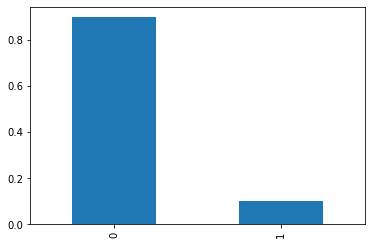

In [11]:
class_frequency = df['toxic'].value_counts(normalize=True)
print(class_frequency)
class_frequency.plot(kind='bar');

Вывод: Видим, что в исходном датафрейме есть дисбаланс классов, который необходимо устранить перед обучением модели, либо в процессе обучения. В нашей работе устранять дисбаланс будет через атрибут взвешивания классов.

Выделим из датасета выборку, содержащую случайные 800 строк и далее будем работать с ней, чтобы избежать проблем нехватки памяти или чрезмерно долгого обучения и создания эмбеддингов.

In [12]:
df = df.sample(800).reset_index(drop=True)

In [13]:
df

,text,toxic
0,The official term are in Block Service Member ...,0
1,Well like I said the sub heading was to resolv...,0
2,No This is the worst possible solution and mak...,0
3,Oh yeah I never said to remove the mention of ...,0
4,OK YOURE A FAG THEN,1
...,...,...
795,Trolling We have provided citations for everyt...,0
796,IrishGuy I don t know if this is the right pla...,0
797,We don t need a FAQ because we have climate ch...,0
798,Fuck off quit lying to people Chumps,1


Токен применительно к NLP - это фразы, слова, символы, на которые разбивается текст в ML. 

Для улучшения качества прогнозирования тональности текста, используем модель BERT, которая была предобучена на негативных комментариях.

Используем веса unitary/toxic-bert, которые были скачаны с сервера Hugging Face.

In [14]:
model_class, tokenizer_class, config_class, pretrained_weights = (ppb.BertModel, ppb.BertTokenizer, \
                                                                  ppb.BertConfig,'unitary/toxic-bert')

# Загрузка предобученной модели/токенизатора 
## создаем токенизатор, который переведет текст в векторное представление - список токенов tokenized. 
## Это первая часть создания эмбеддингов. Эмбеддинги дадут более точное представление о соотношении разных слов и их свойствах
tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
config = config_class.from_pretrained(pretrained_weights)
model = model_class.from_pretrained(pretrained_weights, config=config)

Some weights of the model checkpoint at unitary/toxic-bert were not used when initializing BertModel: ['classifier.weight', 'classifier.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [15]:
#преобразуем текст в номера токенов методом encode
# add_special_tokens = True. Т.е.,к любому преобразуемому тексту добавляется токен начала (101) и токен конца текста (102).
# указали truncation=True, max_length=512, т.к. у BERT есть ограничение по длине максимального преобразуемого вектора

tokenized = df['text'].apply(
    lambda x: tokenizer.encode(x, add_special_tokens=True, truncation=True, max_length=512))

# находим максимальную длину вектора
max_len = 0
for i in tokenized.values:
    if len(i) > max_len:
        max_len = len(i)

# применяем метод padding, чтобы после токенизации все векторы были равной длины (max_len), нули информации не несут
padded = np.array([i + [0]*(max_len - len(i)) for i in tokenized.values])

# заменяем все числа, не равные нулю на 1, создаем "внимание"
attention_mask = np.where(padded != 0, 1, 0)

In [16]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model.to(device);


- Эмбеддинги модель BERT создаёт батчами. Чтобы хватило оперативной памяти, сделаем размер батча небольшим.
- Преобразуем данные в формат тензоров - многомерных векторов в библиотеке torch. Тип данных LongTensor (англ. «длинный тензор») хранит числа в «длинном формате», то есть выделяет на каждое число 64 бита.
- notebook.tqdm используем для отображения процесса
- with torch.no_grad() - для ускорения процесса

In [17]:
## это второй этап создания эмбеддингов для нашего текста
batch_size = 8
embeddings = []
for i in notebook.tqdm(range(padded.shape[0] // batch_size)):
        #преобразуем вектор с номерами токенов с формат тензоров
        batch = torch.LongTensor(padded[batch_size*i:batch_size*(i+1)])  
        #преобразуем вектор маски в формат тензоров
        attention_mask_batch = torch.LongTensor(attention_mask[batch_size*i:batch_size*(i+1)])
        
        with torch.no_grad():
            batch_embeddings = model(batch, attention_mask=attention_mask_batch.to(device)) 
            #модель создает эмбеддинги, работая уже с тензорами
        
        embeddings.append(batch_embeddings[0][:,0,:].cpu().numpy())

  0%|          | 0/100 [00:00<?, ?it/s]

## 2 Обучение

<div class="toc"><ul class="toc-item"><li><span><a href="#Содержание" data-toc-modified-id="Содержание"><span class="toc-item-num"&nbsp;&nbsp;</span>Содержание</a></span></li>
</span></li></ul></div>

<a id='Обучение'></a>

Формируем обучающие и целевые признаки для модели. Обучающие признаки - матрица из эмбеддингов.

In [18]:
features = np.concatenate(embeddings)

In [19]:
target = df['toxic']

Делим признаки на обучающую и тестовые выборки в соотношении 75/25%

In [20]:
features_train, features_test, target_train, target_test = \
train_test_split(features,target, test_size=0.25, random_state=state)

Далее переходим к обучению моделей классификации

Не забываем про необходимость выставления параметра взвешивания классов в обучении моделей, для корректировки дисбаланса.

### 2.1 Модель LogisticRegression

In [21]:
model_lr = LogisticRegression(random_state = state, solver='lbfgs', max_iter=1000, class_weight = 'balanced')

In [22]:
param_grid_lr = { 'C' : np.linspace(0.0001, 200, 20)}

In [23]:
gs_lr = GridSearchCV(
        estimator = model_lr,
        param_grid = param_grid_lr,
        scoring = 'f1',
        cv=5,
        n_jobs = -1,
        verbose = 3,
        error_score='raise')

In [24]:
gs_lr.fit(features_train,target_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


GridSearchCV(cv=5, error_score='raise',
             estimator=LogisticRegression(class_weight='balanced',
                                          max_iter=1000,
                                          random_state=RandomState(MT19937) at 0x1C3D38FDA40),
             n_jobs=-1,
             param_grid={'C': array([1.00000000e-04, 1.05264105e+01, 2.10527211e+01, 3.15790316e+01,
       4.21053421e+01, 5.26316526e+01, 6.31579632e+01, 7.36842737e+01,
       8.42105842e+01, 9.47368947e+01, 1.05263205e+02, 1.15789516e+02,
       1.26315826e+02, 1.36842137e+02, 1.47368447e+02, 1.57894758e+02,
       1.68421068e+02, 1.78947379e+02, 1.89473689e+02, 2.00000000e+02])},
             scoring='f1', verbose=3)

In [25]:
gs_lr_best_score = gs_lr.best_score_
gs_lr_best_params = gs_lr.best_params_
print(f'best_score: {gs_lr_best_score}')
print(f'best_params: {gs_lr_best_params}')

best_score: 0.8878704091607317
best_params: {'C': 0.0001}


### 2.2 Модель RandomForestClassifier

In [26]:
param_grid_rf = {
    'n_estimators': [150,300,500],
    'max_depth': range(2, 20, 2),
    'min_samples_split': [2, 4, 7],
    'min_samples_leaf': [1, 2, 3, 4, 5]
}

In [27]:
model_rf = RandomForestClassifier(class_weight = 'balanced')

In [28]:
rs_rf = RandomizedSearchCV(
        estimator = model_rf,
        param_distributions = param_grid_rf,
        scoring = 'f1',
        cv=5,
        n_jobs = -1,
        random_state=state)

In [29]:
rs_rf.fit(features_train,target_train)

RandomizedSearchCV(cv=5,
                   estimator=RandomForestClassifier(class_weight='balanced'),
                   n_jobs=-1,
                   param_distributions={'max_depth': range(2, 20, 2),
                                        'min_samples_leaf': [1, 2, 3, 4, 5],
                                        'min_samples_split': [2, 4, 7],
                                        'n_estimators': [150, 300, 500]},
                   random_state=RandomState(MT19937) at 0x1C3D38FDA40,
                   scoring='f1')

In [30]:
rs_rf_best_score = rs_rf.best_score_
rs_rf_best_params = rs_rf.best_params_
print(f'best_score: {rs_rf_best_score}')
print(f'best_params: {rs_rf_best_params}')

best_score: 0.8785443209541881
best_params: {'n_estimators': 300, 'min_samples_split': 4, 'min_samples_leaf': 4, 'max_depth': 2}


### 2.4 Модель LGBMClassifier

In [31]:
lgbm = LGBMClassifier(class_weight = 'balanced')

In [32]:
param_grid_lgbm = {
    'max_depth': [5, 6],
    'learning_rate': [.2, .3],
}

In [33]:
gs_lgbm = GridSearchCV(
        estimator = lgbm,
        param_grid = param_grid_lgbm,
        scoring = 'f1',
        cv=5,
        verbose = 3,
        n_jobs = -1)

In [34]:
gs_lgbm.fit(features_train,target_train)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


GridSearchCV(cv=5, estimator=LGBMClassifier(class_weight='balanced'), n_jobs=-1,
             param_grid={'learning_rate': [0.2, 0.3], 'max_depth': [5, 6]},
             scoring='f1', verbose=3)

In [35]:
gs_lgbm_best_score = gs_lgbm.best_score_
gs_lgbm_best_params = gs_lgbm.best_params_
print(f'best_score: {gs_lgbm_best_score}')
print(f'best_params: {gs_lgbm_best_params}')

best_score: 0.8307478728168384
best_params: {'learning_rate': 0.3, 'max_depth': 6}


На этапе обучения моделей нами были рассмотрены 3 типа классификаторов - логистическая регрессия, модель случайного леса, LGBMClassifier. Мы перебрали гиперпараметры моделей через GridSearchCV и RandomizedSearchCV. Далее сравним полученные результаты и проведем тестирование лучшей модели.

### 2.4 Тестирование

In [36]:
analysis = pd.DataFrame({gs_lr_best_score, rs_rf_best_score, gs_lgbm_best_score},
                         index = ['LogRegression','Random Forest Classifier','LgbmClassifier'],\
                        columns = ['F1'])

analysis

,F1
LogRegression,0.887870
Random Forest Classifier,0.878544
LgbmClassifier,0.830748


In [37]:
gs_lgbm_best_score

0.8307478728168384

In [38]:
print(f'Лучшей моделью среди моделей {analysis.index[0]}, {analysis.index[1]}, \
{analysis.index[2]} стала модель {analysis.idxmax()[0]} c результатом {analysis["F1"].max()}')

Лучшей моделью среди моделей LogRegression, Random Forest Classifier, LgbmClassifier стала модель LogRegression c результатом 0.8878704091607317


Проведем тестирование модели RandomForestClassifier.

In [39]:
model_rf = RandomForestClassifier(class_weight = 'balanced', n_estimators = rs_rf_best_params.get('n_estimators'),\
                                  min_samples_split = rs_rf_best_params.get('min_samples_split'), \
                                  min_samples_leaf = rs_rf_best_params.get('min_samples_leaf'),\
                                  max_depth = rs_rf_best_params.get('max_depth'),\
                                  random_state=state)
model_rf.fit(features_train,target_train)
pr_rf = model_rf.predict(features_test)
f1_rf_test = f1_score(target_test,pr_rf)
f1_rf_test

0.9166666666666666

## 3 Выводы

<div class="toc"><ul class="toc-item"><li><span><a href="#Содержание" data-toc-modified-id="Содержание"><span class="toc-item-num"&nbsp;&nbsp;</span>Содержание</a></span></li>
</span></li></ul></div>

<a id='Выводы'></a>

В ходе выполнения проекта мы обучили модель Случайного Леса определять тональность текста, f1 мера при тестировании модели равна 0.92, что выше минимального значения, которое требовалось по условиям проекта.